# BI - Laboratorio 2
- Manuel Felipe Carvajal Parra 202014203

## 0. Imports

In [35]:
# Librerías para manipulación y cálculo numérico
import numpy as np
import pandas as pd

# Configuración de pandas para visualizar más filas y columnas
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

# -------------------------------------------
# Utilidades para guardar y cargar modelos
from joblib import dump, load

# -------------------------------------------
# Librerías para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------
# Herramientas de scikit-learn para preparación de datos y modelado
# División de datos, regresión lineal y creación de pipelines y transformaciones
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# Métricas para evaluar el modelo de regresión
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------------------------
# Funciones estadísticas adicionales
import scipy.stats as stats

# -------------------------------------------
from sklearn.cluster import KMeans

# Librerías para análisis de datos
#from ydata_profiling import ProfileReport

## 1. Carga de datos

En esta sección se explica cómo se carga el conjunto de datos que se utilizará a lo largo del laboratorio. Se suele emplear la función pd.read_csv (o funciones similares) para leer archivos con formato CSV, Excel u otros, permitiendo convertir la información en un DataFrame de pandas. Así, se asegura que la data esté disponible para realizar análisis exploratorio, procesamiento y modelado posterior.

In [36]:
df = pd.read_csv("Datos_SenecaféAlpes.csv", sep=";", encoding="utf-8-sig")


print(df.columns[:5])


Index(['ID', 'Area', 'Perimetro', 'LongitudEjeMayor', 'LongitudEjeMenor'], dtype='object')


## 2. Entendimiento de los datos

En esta sección se realiza un análisis exploratorio para obtener una visión general del conjunto de datos de los granos de café. El objetivo es identificar posibles problemas de calidad, detectar valores atípicos y entender la distribución de las variables numéricas. Estas visualizaciones permiten conocer el comportamiento de los datos antes de aplicar los algoritmos de agrupación.


### 2.1 Analisis numerico

A continuación se seleccionan las variables numéricas del dataset, que corresponden a las medidas geométricas y morfológicas de los granos de café. Estas variables serán la base para la aplicación de los algoritmos de agrupación, ya que contienen la información cuantitativa relevante.


In [37]:
numericas = [
    'Area', 'Perimetro', 'LongitudEjeMayor', 'LongitudEjeMenor',
    'Excentricidad', 'AreaConvexa', 'DiametroEquivalente', 'Medida',
    'Solidez', 'Redondez', 'Compacidad',
    'FactorForma1', 'FactorForma2', 'FactorForma3', 'FactorForma4'
]

print("Número de variables numéricas seleccionadas:", len(numericas))
print(numericas[:8], "...")


Número de variables numéricas seleccionadas: 15
['Area', 'Perimetro', 'LongitudEjeMayor', 'LongitudEjeMenor', 'Excentricidad', 'AreaConvexa', 'DiametroEquivalente', 'Medida'] ...


##### 2.1.1. Gráficas de dispersión

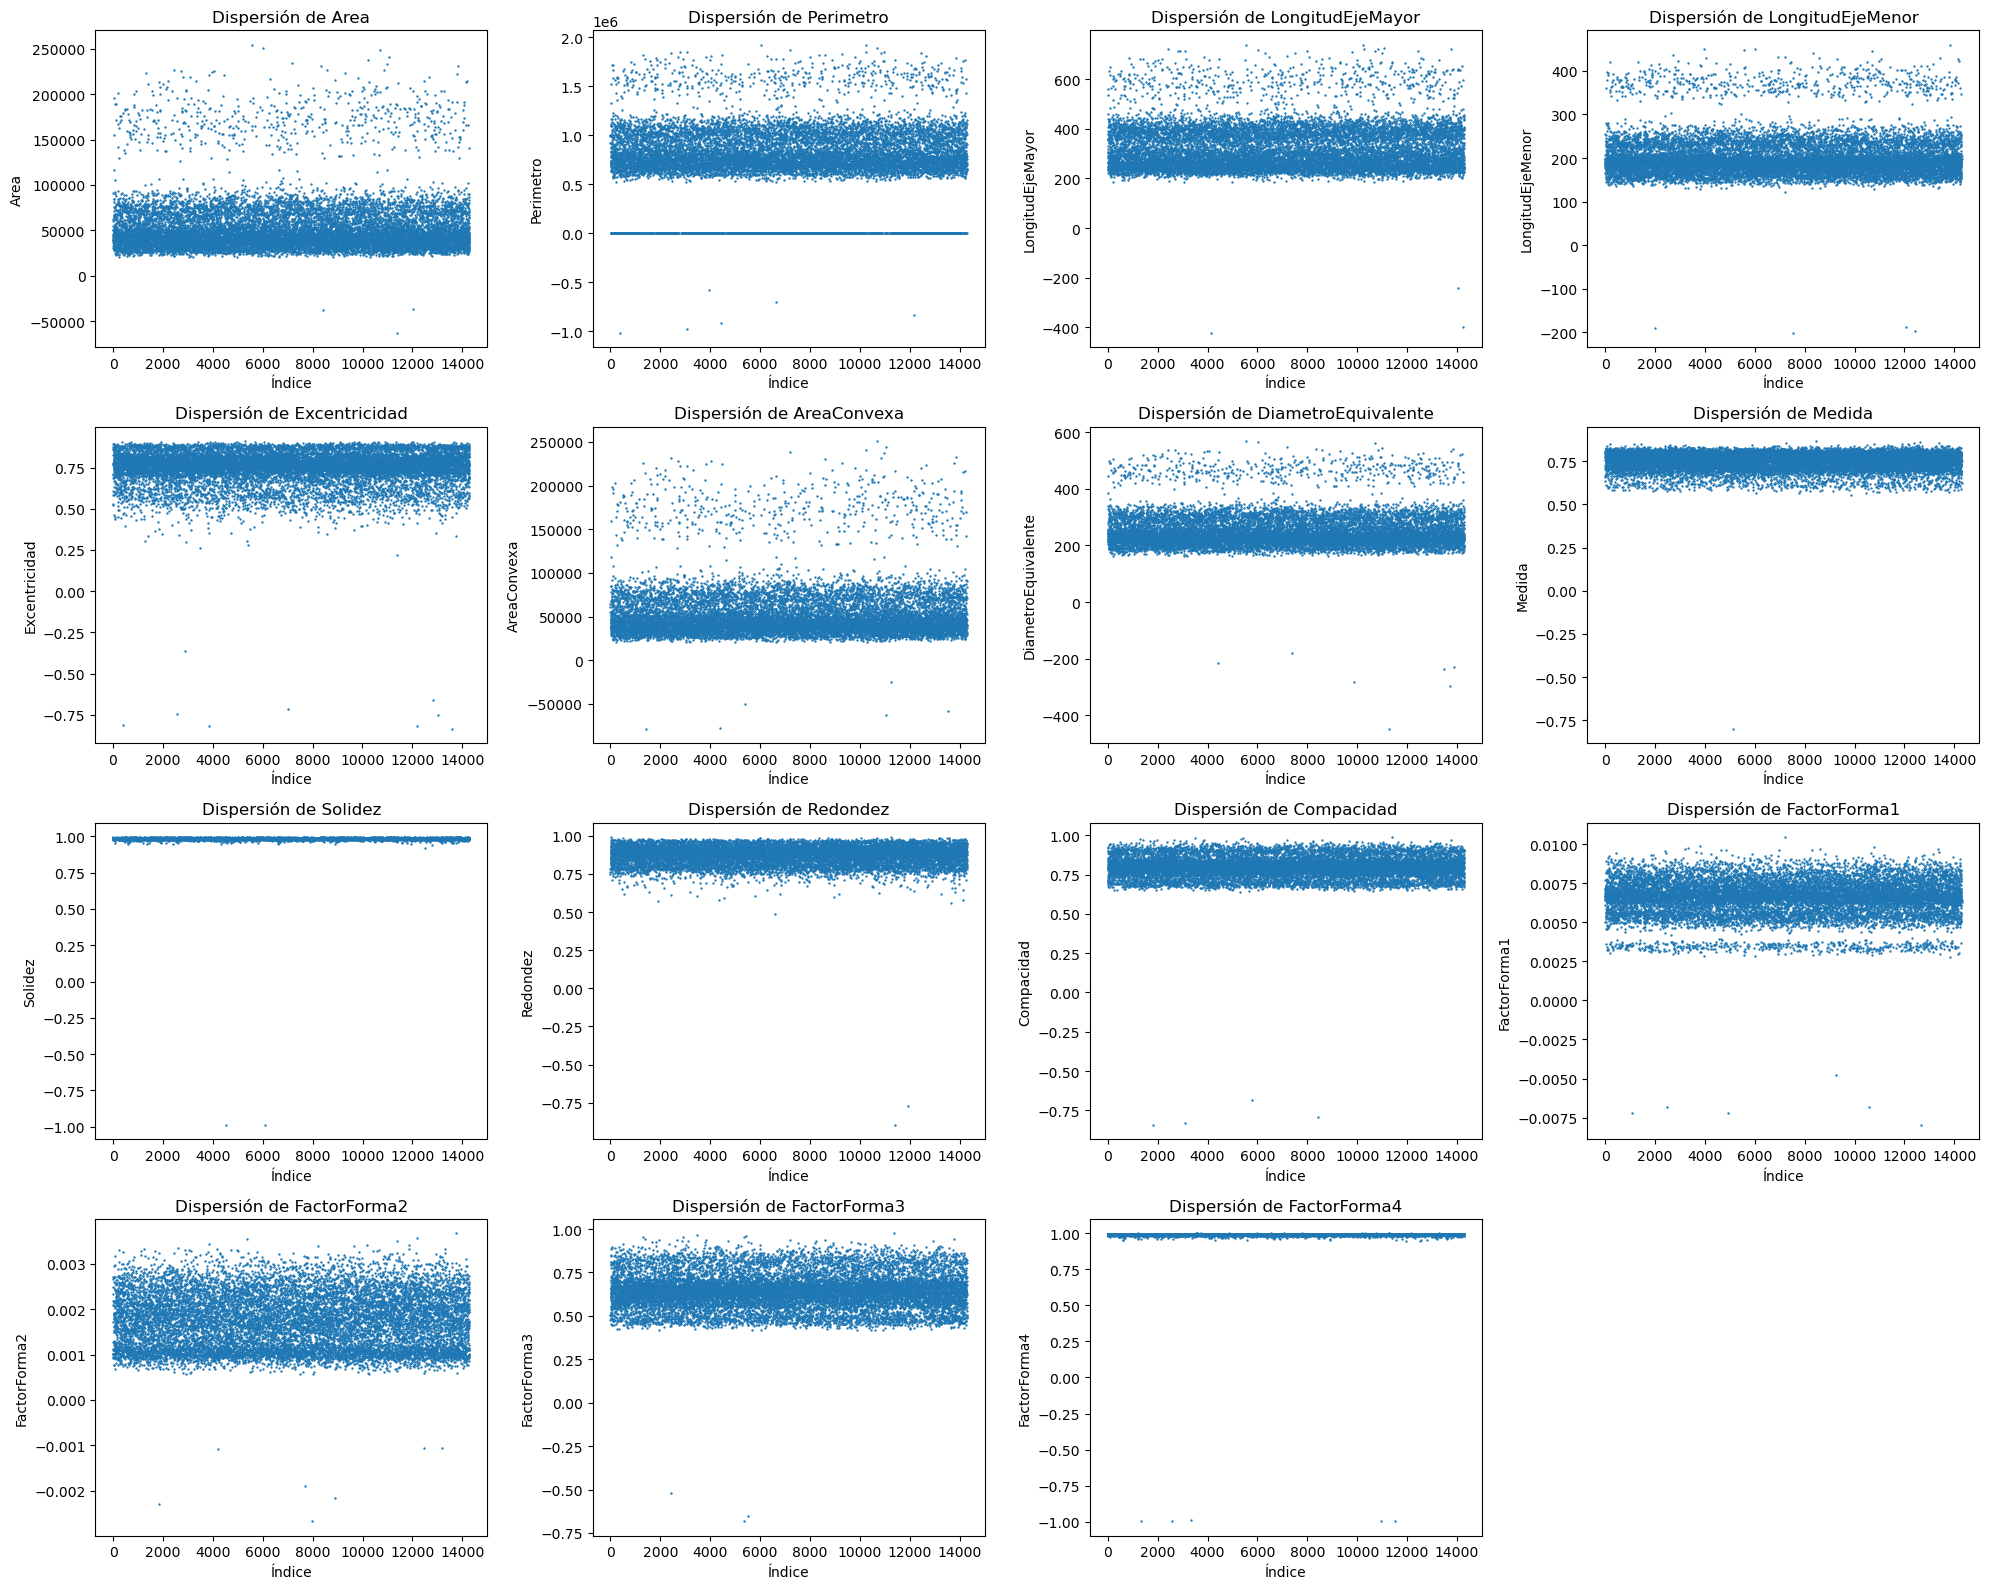

In [38]:
import math

# Configuración de subplots
columnas_por_fila = 4
filas = math.ceil(len(numericas) / columnas_por_fila)
fig, ejes = plt.subplots(filas, columnas_por_fila, figsize=(columnas_por_fila * 5, filas * 4))
ejes = ejes.flatten()

# Graficar cada variable numérica
for eje, columna in zip(ejes, numericas):
    eje.scatter(df.index, df[columna], s=0.5)
    eje.set_xlabel("Índice")
    eje.set_ylabel(columna)
    eje.set_title(f"Dispersión de {columna}")

# Ocultar subplots vacíos
for eje in ejes[len(numericas):]:
    eje.set_visible(False)

plt.tight_layout()
plt.show()


##### 2.1.2 Histogramas

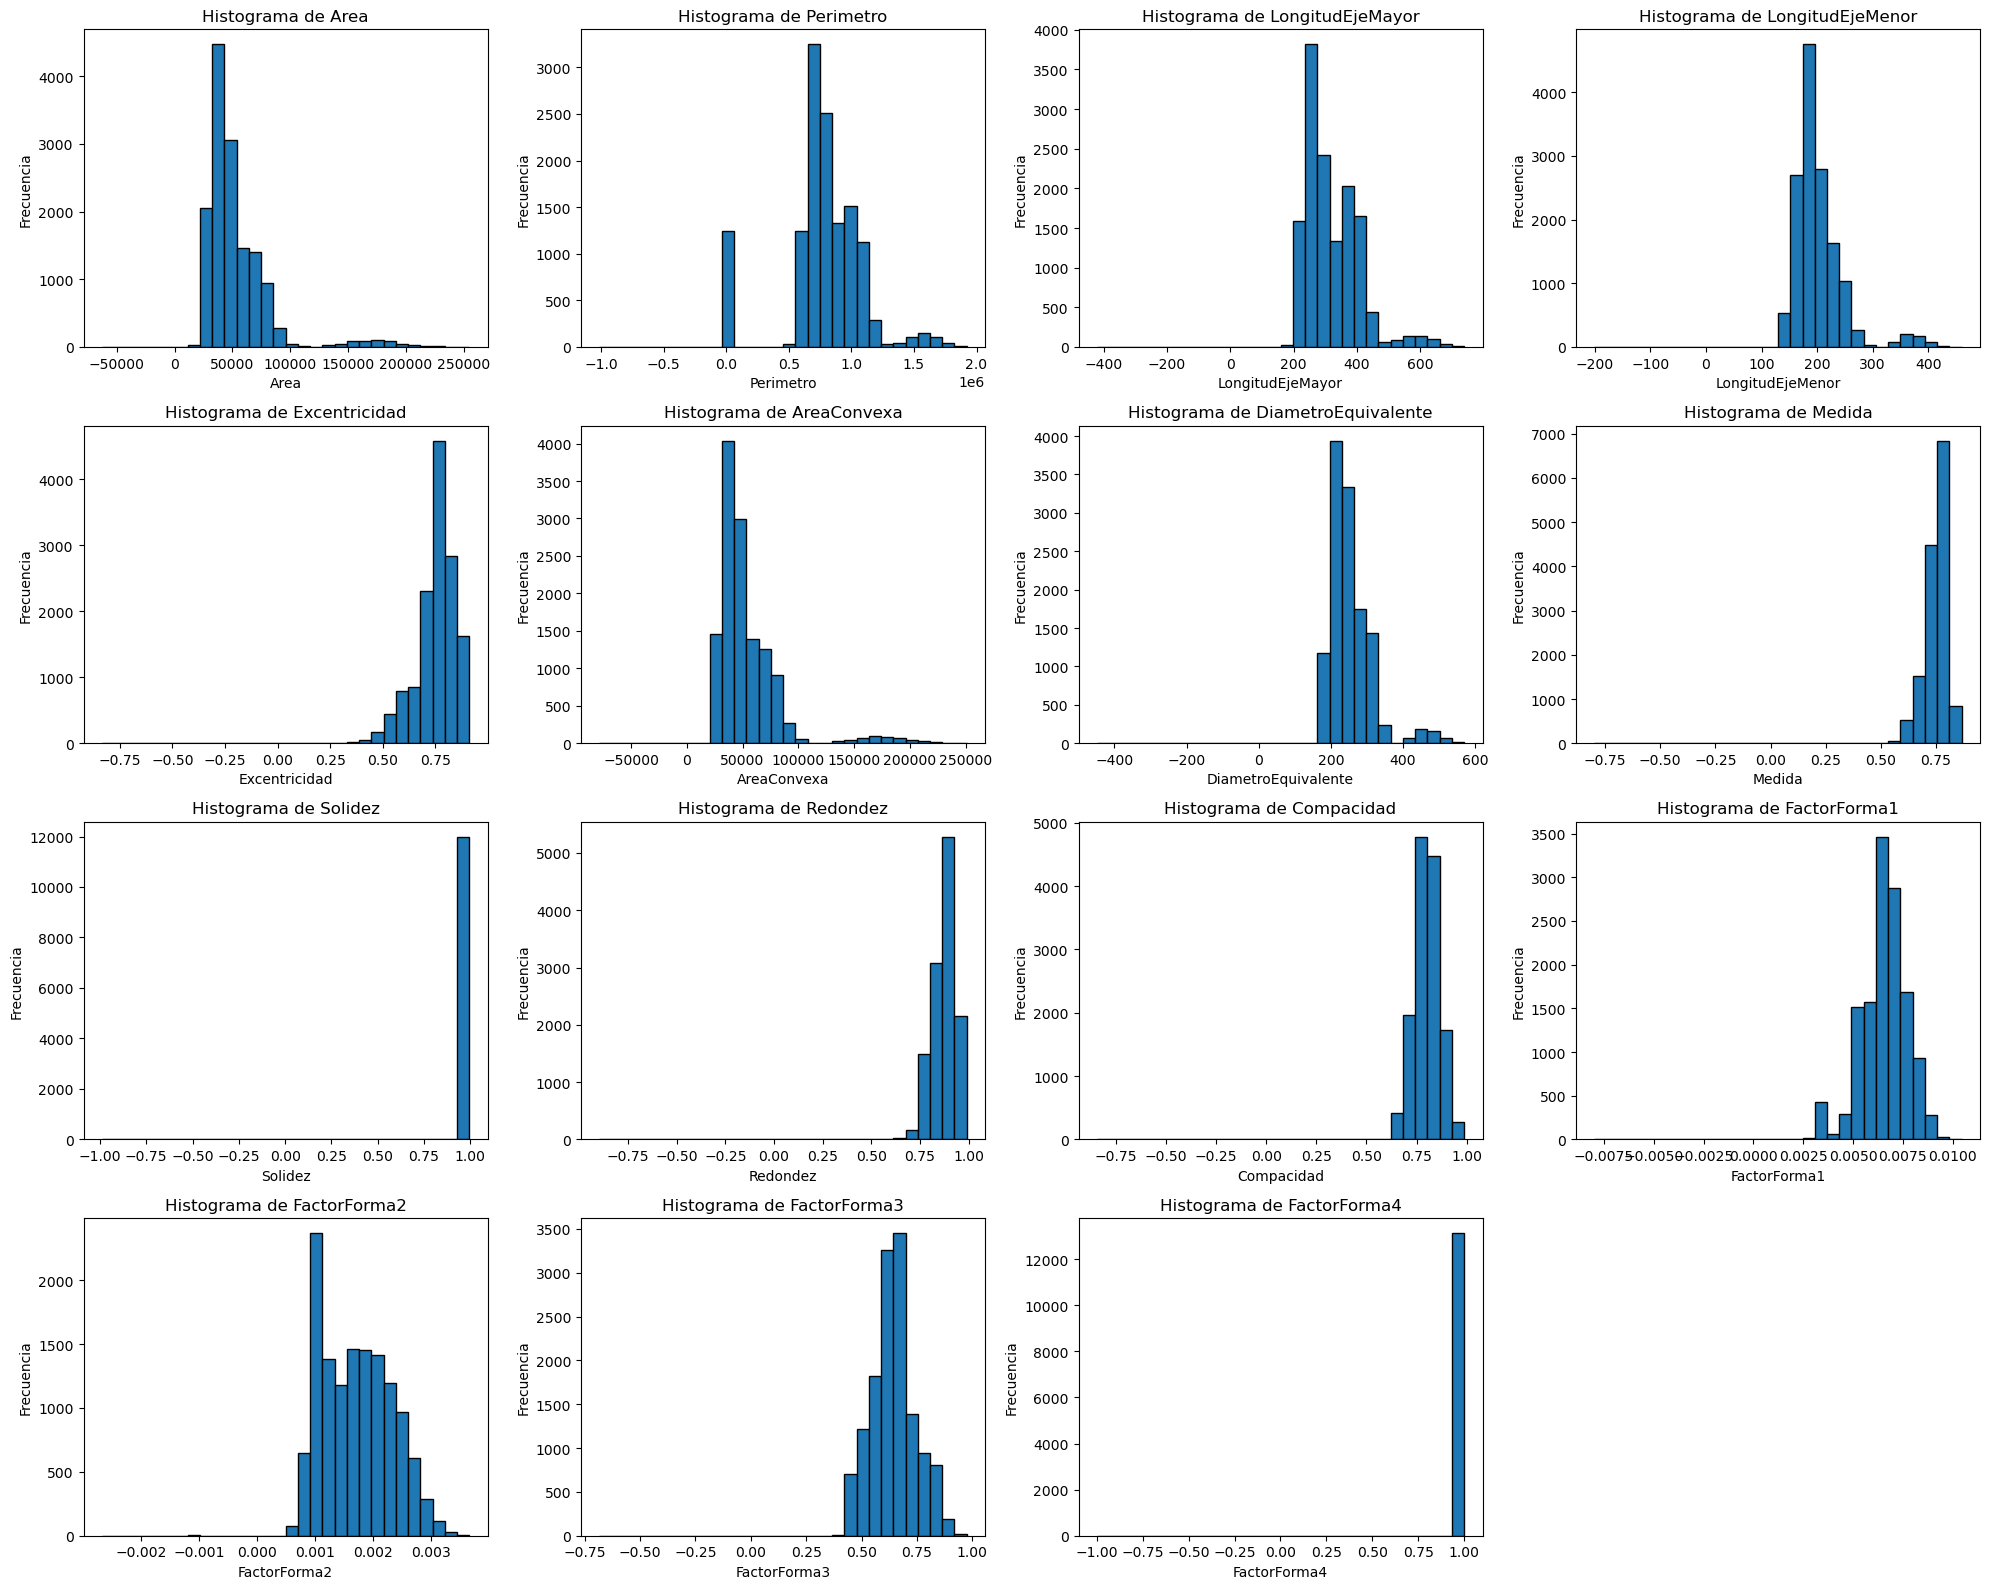

In [39]:
import math

# Parámetros de la grilla
columnas_por_fila = 4
filas_histo = math.ceil(len(numericas) / columnas_por_fila)

fig, axes_hist = plt.subplots(filas_histo, columnas_por_fila, figsize=(columnas_por_fila * 5, filas_histo * 4))
axes_hist = axes_hist.flatten()

for ax, col in zip(axes_hist, numericas):
    datos_col = df[col].dropna()
    ax.hist(datos_col, bins=30, edgecolor="black")
    ax.set_title(f"Histograma de {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frecuencia")

# Ocultar subplots sobrantes
for ax in axes_hist[len(numericas):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


##### 2.1.3 Boxplots

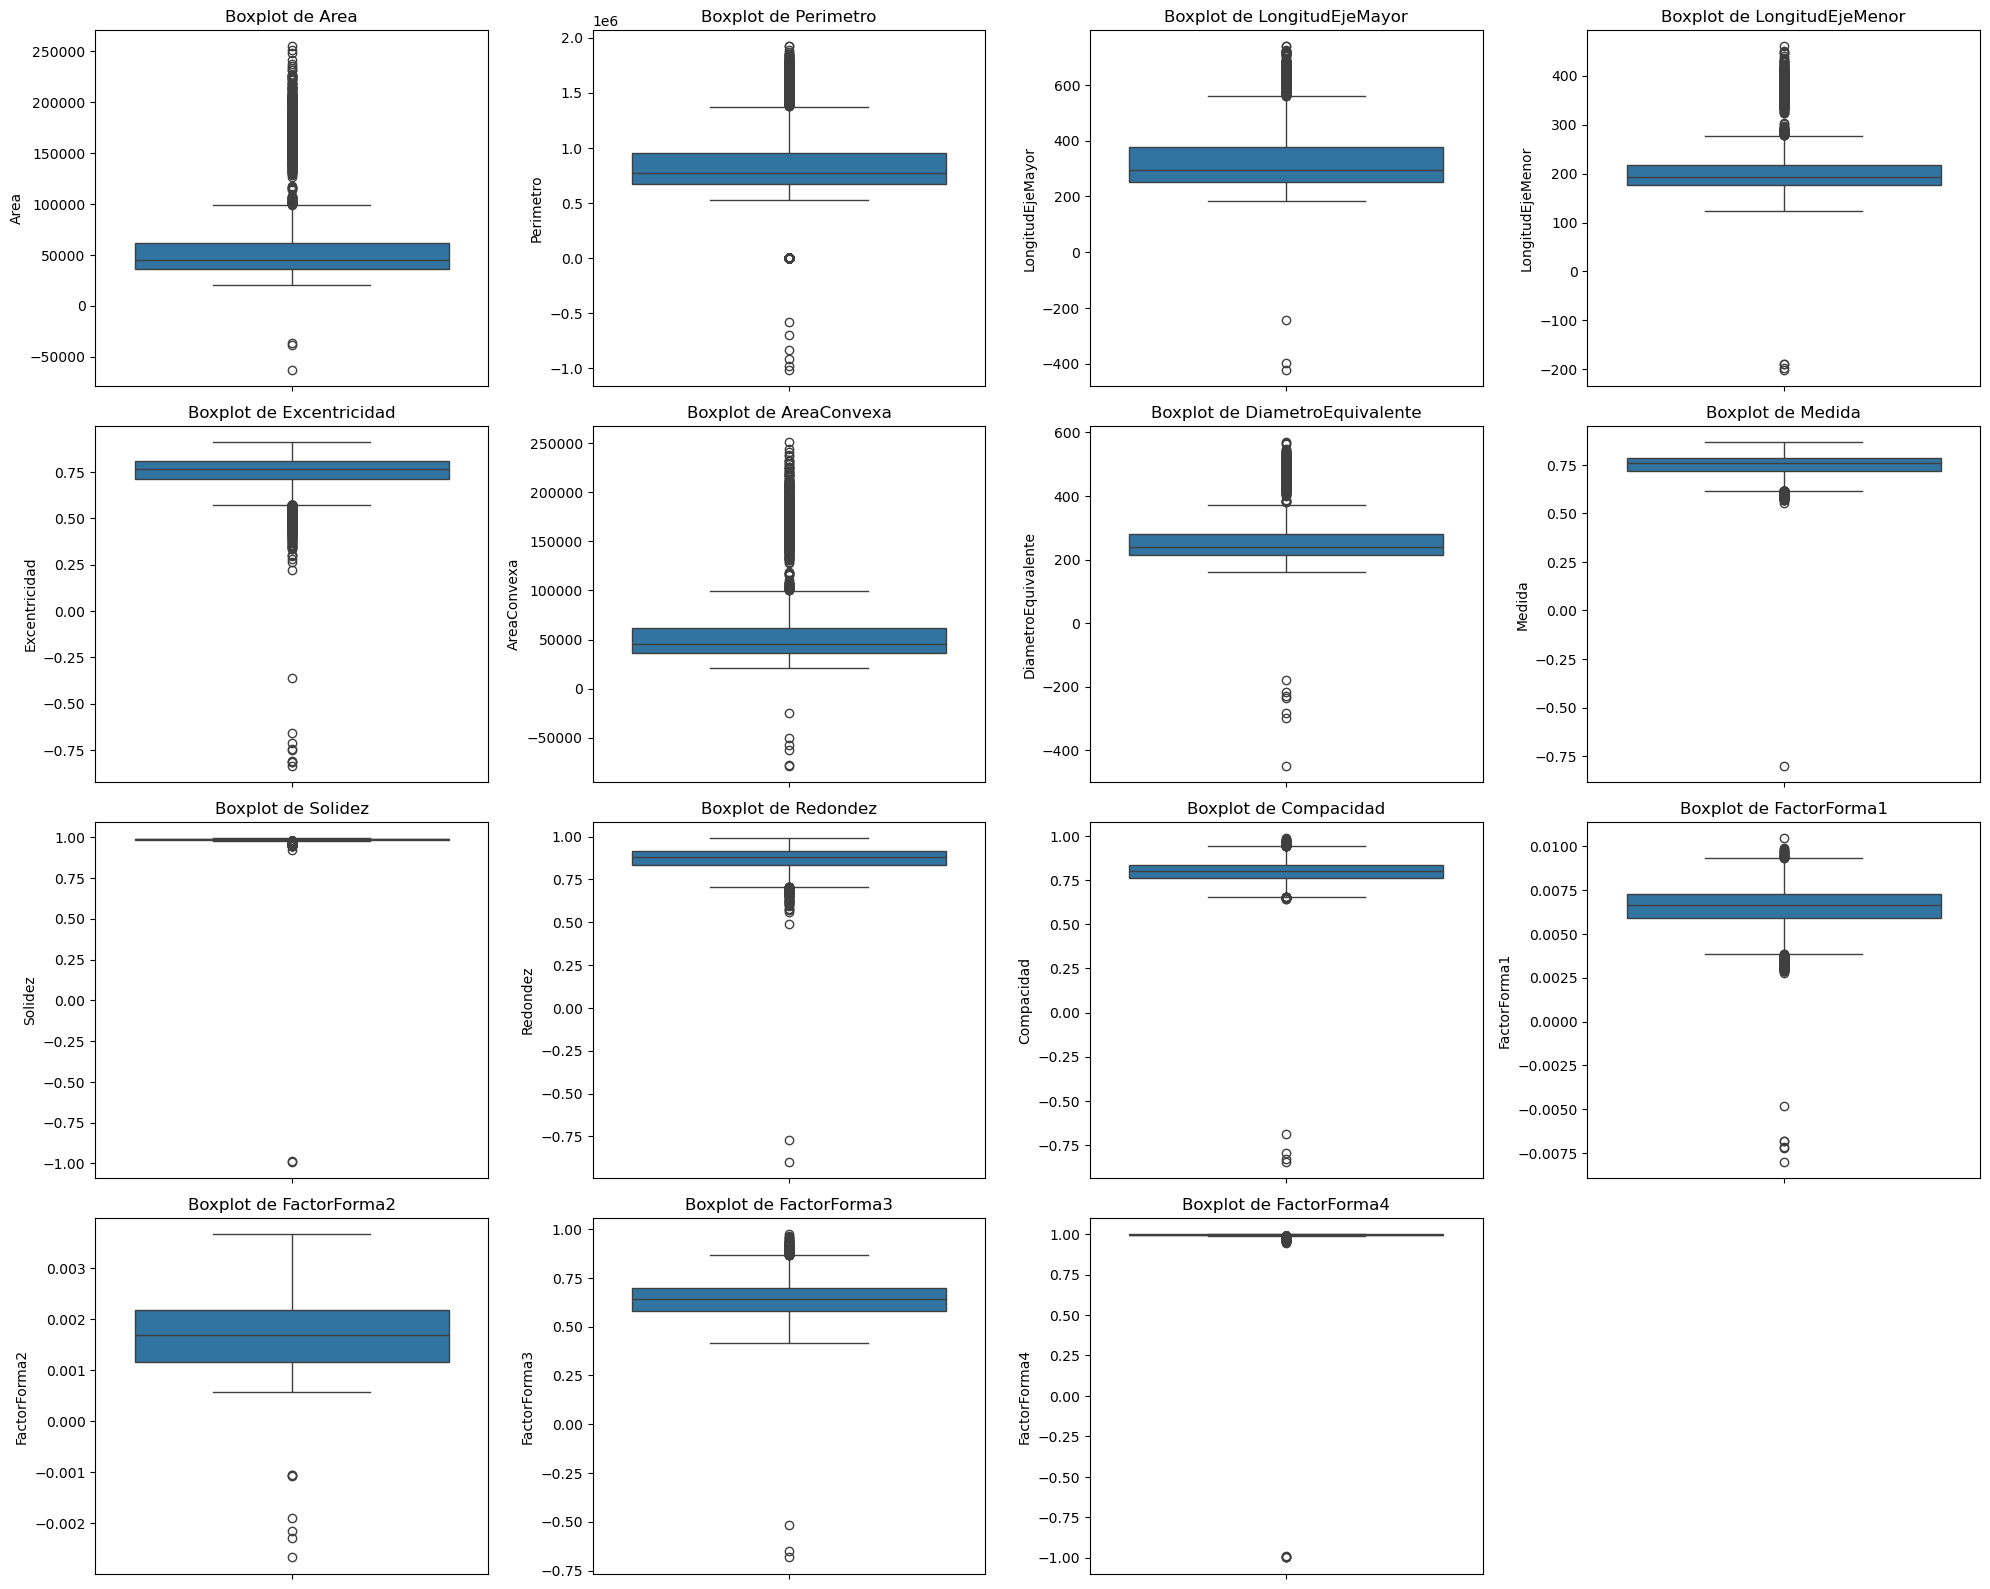

In [40]:
# Parámetros de la grilla
columnas_por_fila = 4
filas_boxplot = math.ceil(len(numericas) / columnas_por_fila)

fig, axes_box = plt.subplots(filas_boxplot, columnas_por_fila, figsize=(columnas_por_fila * 5, filas_boxplot * 4))
axes_box = axes_box.flatten()

for ax, col in zip(axes_box, numericas):
    sns.boxplot(y=df[col], ax=ax)
    ax.set_title(f"Boxplot de {col}")
    ax.set_ylabel(col)

# Ocultar subplots sobrantes
for ax in axes_box[len(numericas):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


#### 2.1.4 Conclusiones iniciales sobre las variables numéricas

Del análisis de las gráficas de dispersión, histogramas y boxplots se destacan las siguientes observaciones:

1. Escalas muy diferentes entre variables  
   Algunas variables como Área, Perímetro, LongitudEjeMayor y ÁreaConvexa alcanzan valores en el orden de cientos de miles, mientras que otras como Solidez, Redondez, Compacidad, Medida y los Factores de forma están acotadas entre 0 y 1. Esto confirma la necesidad de aplicar escalado o normalización antes de entrenar los algoritmos de agrupación.

2. Distribuciones asimétricas y sesgos  
   Varias variables presentan distribuciones sesgadas hacia la derecha, por ejemplo Área, Perímetro y DiametroEquivalente. En el caso de las variables acotadas, como Solidez y Redondez, la mayoría de valores se concentran en el extremo superior. Estos patrones de distribución podrían requerir transformaciones (como logaritmos) para estabilizar la varianza.

3. Valores atípicos (outliers)  
   Los boxplots muestran una gran cantidad de valores extremos en casi todas las variables. Incluso se observan registros negativos en variables que conceptualmente deberían ser positivas, como Área, Perímetro y DiametroEquivalente. Estos casos deben ser evaluados para decidir si se eliminan, se imputan o se mantienen.

4. Variables con poca variabilidad  
   Algunas variables como Solidez y FactorForma4 están muy concentradas en valores cercanos a 1, lo que limita su poder discriminante para diferenciar grupos. Es posible que tengan poca relevancia para el clustering.

5. Implicaciones para el modelado  
   - Algoritmos como K-Means y Gaussian Mixture son sensibles a las diferencias de escala y a los outliers, por lo que se debe asegurar un preprocesamiento cuidadoso.  
   - Algoritmos más robustos como DBSCAN o Agglomerative Clustering podrían ser útiles para manejar distribuciones irregulares y valores extremos.  
   - Será necesario complementar este análisis con una matriz de correlación para evitar redundancia de variables antes de modelar.

En conclusión, los datos presentan heterogeneidad en escalas, distribuciones sesgadas y valores atípicos que deberán ser tratados en la etapa de preparación, con el fin de garantizar resultados consistentes en los algoritmos de agrupación.


## 2.2 Análisis del perfilamiento

En esta sección se revisa la calidad del conjunto de datos desde varios ángulos: filas duplicadas, valores nulos, estadísticas descriptivas, correlaciones entre variables numéricas y verificación de rangos plausibles según el diccionario. Este perfilamiento permite detectar problemas antes de la preparación y el modelado.


### 2.2.1 Análisis de filas duplicadas


En esta celda se identifican registros duplicados de dos formas. Primero, se buscan filas idénticas en todas las columnas. Segundo, se verifica si existen códigos ID repetidos, asumiendo que el identificador debe ser único por grano. Si se encuentran duplicados, se listan ejemplos para su inspección.


In [41]:
# Filas completamente duplicadas en el DataFrame
duplicadas_df = df[df.duplicated(keep=False)]
n_duplicadas = df.duplicated().sum()

print("Cantidad de filas duplicadas:", n_duplicadas)
display(duplicadas_df.head(5))

# Duplicados por ID (si el ID debería ser único)
if "ID" in df.columns:
    dup_por_id = df[df["ID"].duplicated(keep=False)].sort_values("ID")
    n_ids_dup = df["ID"].duplicated().sum()
    print("\nCantidad de IDs repetidos:", n_ids_dup)
    display(dup_por_id.head(5))


Cantidad de filas duplicadas: 461


,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
16,G000100,33143,NaN,222.526309,189.737379,Redondeado,0.522480,33377.0,205.423899,0.769980,0.992989,0.990685,0.923144,0.006714,NaN,0.852195,NaN,Normal,NaN
20,G012961,36876,707667.0,261.019476,180.562424,Alargado,0.722129,37270.0,216.684059,0.716136,0.989428,0.925328,0.830145,0.007078,0.002074,0.689141,0.996216,Normal,Natural
30,G009056,45954,795062.0,294.820672,199.020609,Alargado,0.737766,46398.0,241.889334,0.780296,0.990431,0.913548,0.820463,0.006416,0.001793,0.673159,0.997189,Normal,Lavado
37,G000534,36568,691529.0,241.392193,193.119305,Redondeado,0.599969,36883.0,215.777255,0.789669,0.991459,0.960927,0.893887,0.006601,0.002600,0.799033,0.998763,Normal,Lavado
40,G011077,29081,636593.0,237.301527,156.431380,Alargado,0.751959,29481.0,192.424217,0.703680,0.986432,0.901769,0.810885,0.008160,0.002176,0.657534,0.997459,Normal,Natural



Cantidad de IDs repetidos: 680


,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
7772,G000009,30685,635681.0,213.534145,183.157146,Redondeado,0.514081,31044.0,197.659696,0.771561,NaN,0.954240,0.925658,0.006959,0.003152,0.856844,0.998953,NaN,Lavado
824,G000009,30685,635681.0,213.534145,183.157146,Redondeado,0.514081,31044.0,197.659696,0.771561,NaN,0.954240,0.925658,0.006959,0.003152,0.856844,0.998953,NaN,Lavado
13306,G000036,31992,640338.0,212.887364,191.487254,Redondeado,0.436968,32258.0,NaN,0.774212,0.991754,0.980466,0.948038,0.006654,0.003316,0.898777,NaN,NaN,Lavado
1246,G000036,31992,640338.0,212.887364,191.487254,Redondeado,0.436968,32258.0,NaN,0.774212,0.991754,0.980466,0.948038,0.006654,0.003316,0.898777,NaN,NaN,Lavado
11738,G000048,32218,653595.0,222.756071,184.404684,Redondeado,0.560976,32566.0,202.536988,0.754432,0.989314,0.947744,0.909232,0.006914,0.002915,0.826703,0.998636,NaN,Lavado


Se encontraron 461 filas duplicadas en el dataset. Además, también se detectaron identificadores (ID) repetidos, lo que confirma que no todos los registros representan granos únicos. Esto puede deberse a errores en la captura de datos o a la existencia de granos registrados varias veces en el proceso de segmentación.
Para la preparación será necesario decidir si se eliminan estos duplicados para evitar sesgos en el análisis de agrupación, ya que podrían inflar artificialmente ciertos clusters.

### 2.2.2 Valores nulos


En esta celda se cuantifica la presencia de valores nulos por columna y se visualiza su porcentaje. Esta información ayuda a decidir estrategias de imputación o eliminación en la fase de preparación, considerando el impacto de cada variable en el análisis.


,n_nulos,%_nulos
DefectoVisible,2935,20.54
Solidez,2306,16.14
Redondez,2063,14.44
DiametroEquivalente,1923,13.46
AreaConvexa,1423,9.96
Perimetro,1237,8.66
FactorForma4,1159,8.11
FactorForma1,1119,7.83
FactorForma2,1106,7.74
Compacidad,650,4.55


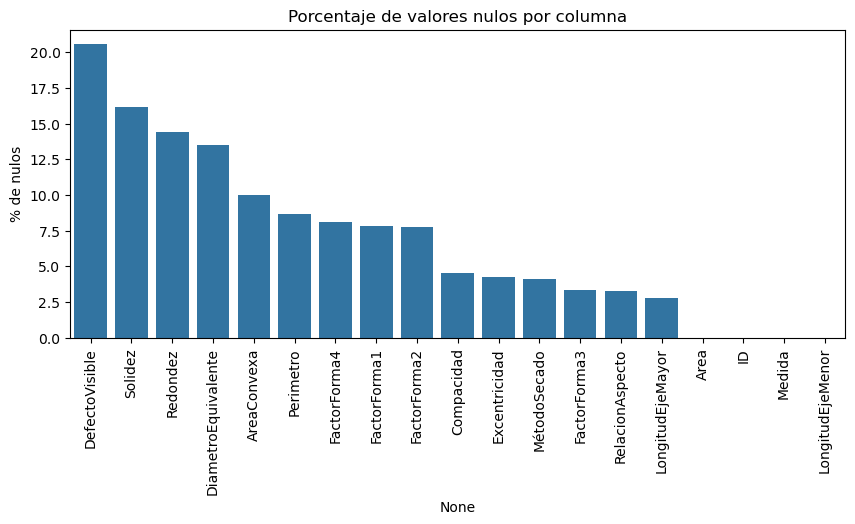

In [42]:
# Conteo y porcentaje de nulos por columna
nul_count = df.isna().sum().sort_values(ascending=False)
nul_pct = (df.isna().mean().sort_values(ascending=False) * 100).round(2)
nulos = pd.concat([nul_count, nul_pct], axis=1)
nulos.columns = ["n_nulos", "%_nulos"]
display(nulos)

# Visualización rápida de nulos por columna
plt.figure(figsize=(10, 4))
sns.barplot(x=nulos.index, y=nulos["%_nulos"])
plt.xticks(rotation=90)
plt.ylabel("% de nulos")
plt.title("Porcentaje de valores nulos por columna")
plt.show()


En cuanto a los valores nulos, se observó que varias variables presentan porcentajes considerables de ausencia de información. DefectoVisible es la más afectada con alrededor del 20 por ciento de registros sin valor, mientras que Solidez, Redondez y DiametroEquivalente superan el 13 por ciento. Otras variables geométricas como Área, LongitudEjeMayor y LongitudEjeMenor casi no presentan datos faltantes. Esta situación implica que deben adoptarse distintas estrategias de tratamiento: en variables categóricas como DefectoVisible puede ser útil asignar la categoría “Desconocido”, y en las variables numéricas con porcentajes intermedios de nulos conviene emplear técnicas de imputación como la media, la mediana o métodos más robustos. Por su parte, las variables sin datos faltantes no requieren ajustes adicionales.

### 2.2.3 Estadísticas descriptivas de variables numéricas


En esta celda se resumen medidas descriptivas por variable numérica, incluyendo percentiles, medias y dispersiones. También se reportan el sesgo y la curtosis para evaluar asimetrías y colas pesadas, lo que orienta decisiones sobre transformaciones y escalado.


In [43]:
# Estadísticos básicos de las variables numéricas seleccionadas previamente
desc = df[numericas].describe().T
display(desc)

# Medidas adicionales útiles para sesgo y curtosis
extra = pd.DataFrame({
    "skew": df[numericas].skew(numeric_only=True),
    "kurtosis": df[numericas].kurt(numeric_only=True)
}).round(3)
display(extra)


,count,mean,std,min,25%,50%,75%,max
Area,14291.0,53055.408999,29396.080372,-6.271600e+04,36338.000000,44660.000000,61311.000000,2.546160e+05
Perimetro,13054.0,772986.954791,326649.281155,-1.012143e+06,676860.750000,772034.500000,955409.750000,1.921685e+06
LongitudEjeMayor,13890.0,319.985592,86.378452,-4.214447e+02,253.319858,296.682345,376.548109,7.388602e+02
LongitudEjeMenor,14291.0,202.178613,45.494541,-2.008387e+02,175.881052,192.437870,216.847844,4.601985e+02
Excentricidad,13687.0,0.749977,0.099438,-8.350038e-01,0.715144,0.764392,0.810441,9.114230e-01
AreaConvexa,12868.0,53575.397809,29566.387814,-7.842300e+04,36720.000000,45107.500000,62109.250000,2.510820e+05
DiametroEquivalente,12368.0,253.001741,60.542330,-4.484026e+02,215.302463,238.579492,279.672481,5.693744e+02
Medida,14291.0,0.749844,0.050774,-7.987057e-01,0.718767,0.760232,0.786942,8.661946e-01
Solidez,11985.0,0.986774,0.025947,-9.890416e-01,0.985597,0.988279,0.989991,9.943782e-01
Redondez,12228.0,0.873080,0.063237,-8.968612e-01,0.832824,0.883353,0.916803,9.906854e-01


,skew,kurtosis
Area,2.933,10.732
Perimetro,-0.574,2.011
LongitudEjeMayor,1.232,3.272
LongitudEjeMenor,1.989,7.869
Excentricidad,-3.001,33.344
AreaConvexa,2.893,10.778
DiametroEquivalente,1.450,8.252
Medida,-2.797,60.768
Solidez,-73.625,5601.860
Redondez,-3.753,87.443


Las estadísticas muestran que algunas variables como Área, Perímetro, LongitudEjeMayor y ÁreaConvexa tienen valores negativos, lo cual no es consistente con su definición geométrica y sugiere la existencia de errores de registro o problemas en la extracción de características. Además, varias variables presentan rangos muy amplios y desviaciones estándar elevadas, lo que confirma la heterogeneidad en las escalas del dataset. Variables como Solidez y FactorForma4 se concentran en valores muy altos cercanos a 1, lo que implica baja variabilidad y poca capacidad discriminante entre observaciones.

El análisis de sesgo y curtosis indica que muchas variables tienen distribuciones fuertemente asimétricas y con colas pesadas. Por ejemplo, Área y ÁreaConvexa presentan un sesgo positivo con curtosis elevada, lo que refleja la presencia de colas largas hacia valores altos. En contraste, variables como Solidez y FactorForma4 muestran sesgos y curtosis extremadamente altos debido a su concentración en un rango muy reducido. Estas características sugieren la necesidad de transformaciones y del uso de escaladores robustos para que los algoritmos de agrupación no se vean dominados por valores extremos.

### 2.2.4 Correlación entre variables numéricas


En esta celda se calcula y se grafica la matriz de correlación de Pearson para las variables numéricas. Luego se listan los pares de variables con mayor correlación absoluta. Esta revisión permite identificar redundancias que podrían simplificarse antes del modelado o tenerse en cuenta al interpretar los clusters.


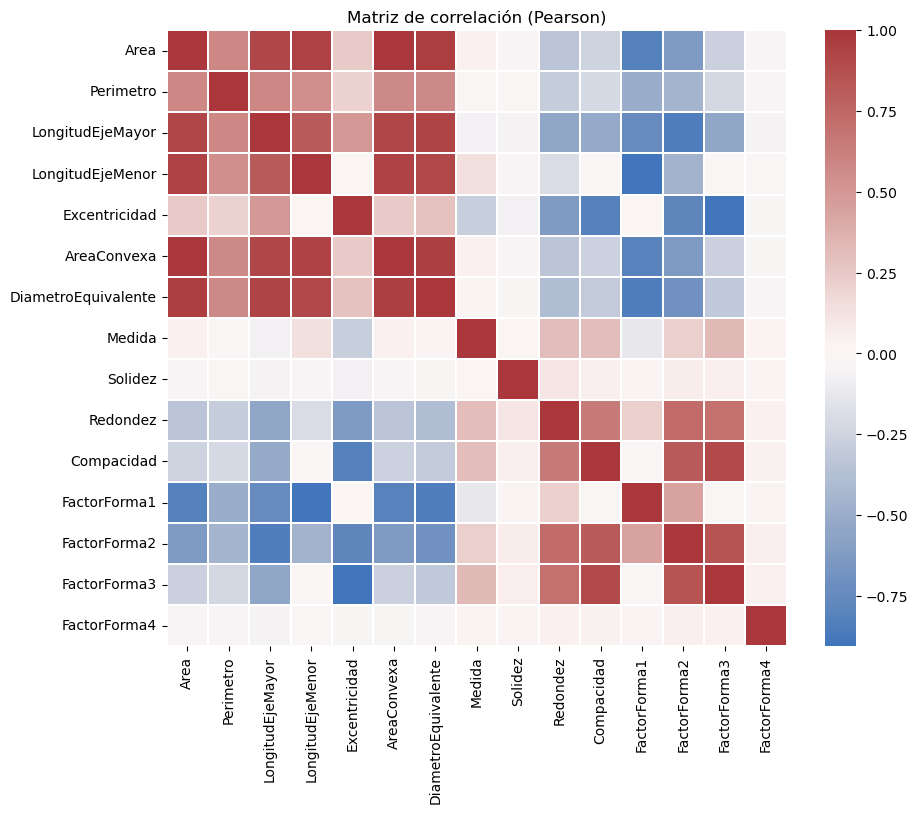

,var_1,var_2,corr_abs
0,Area,AreaConvexa,0.994689
1,Area,DiametroEquivalente,0.958933
2,AreaConvexa,DiametroEquivalente,0.952511
3,Area,LongitudEjeMenor,0.940869
4,LongitudEjeMenor,AreaConvexa,0.935487
5,LongitudEjeMayor,DiametroEquivalente,0.931813
6,Area,LongitudEjeMayor,0.924025
7,LongitudEjeMayor,AreaConvexa,0.920834
8,LongitudEjeMenor,DiametroEquivalente,0.913890
9,LongitudEjeMenor,FactorForma1,0.905972


In [44]:
corr = df[numericas].corr(method="pearson")
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="vlag", center=0, linewidths=.25)
plt.title("Matriz de correlación (Pearson)")
plt.show()

# Top correlaciones absolutas más altas (excluye 1.0 en la diagonal)
corr_abs = corr.abs()
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
top_pairs = (
    upper.stack()
         .sort_values(ascending=False)
         .head(15)
         .rename("corr_abs")
         .reset_index()
         .rename(columns={"level_0": "var_1", "level_1": "var_2"})
)
display(top_pairs)


## 2.3 Análisis de calidad

En esta sección se evalúa la calidad de los datos considerando cuatro dimensiones principales:

- Completitud: se revisa el grado en que las variables presentan valores faltantes o ausentes.  
- Unicidad: se analiza la existencia de registros o identificadores duplicados que puedan afectar la confiabilidad del dataset.  
- Consistencia: se identifican posibles discrepancias en los valores que indiquen errores de captura o cálculo.  
- Validez: se comprueba que los valores respeten los formatos y rangos esperados de acuerdo con la definición de cada variable.  

El análisis de calidad permite determinar qué tan confiables y útiles son los datos para el proceso de agrupación.


### 2.3.1 Completitud


El análisis de completitud muestra la cantidad y el porcentaje de valores nulos por columna. En este dataset se observa que variables como DefectoVisible y Solidez presentan porcentajes elevados de valores ausentes, mientras que otras como Área o LongitudEjeMayor prácticamente no tienen faltantes. Esto sugiere que será necesario aplicar estrategias de imputación diferenciadas según la naturaleza de cada variable.


In [45]:
# Conteo y porcentaje de valores nulos por columna
faltantes = df.isnull().sum()
porcentaje_faltante = 100 * df.isnull().sum() / len(df)

completitud = pd.DataFrame({
    "Valores_faltantes": faltantes,
    "Porcentaje": porcentaje_faltante.round(2)
}).sort_values(by="Porcentaje", ascending=False)

display(completitud)


,Valores_faltantes,Porcentaje
DefectoVisible,2935,20.54
Solidez,2306,16.14
Redondez,2063,14.44
DiametroEquivalente,1923,13.46
AreaConvexa,1423,9.96
Perimetro,1237,8.66
FactorForma4,1159,8.11
FactorForma1,1119,7.83
FactorForma2,1106,7.74
Compacidad,650,4.55


### 2.3.2 Unicidad


El análisis de unicidad confirma que existen registros con identificadores repetidos. Esto significa que no todos los granos tienen un código único en el dataset. Para evitar sesgos en los resultados de agrupación será necesario eliminar los duplicados o decidir una forma de consolidarlos en la etapa de preparación.


In [50]:
# Verificación de unicidad en la columna ID
ids_duplicados = df["ID"].duplicated().sum()
print("Cantidad de IDs duplicados:", ids_duplicados)


Cantidad de IDs duplicados: 680


In [47]:
import re

# 1) Localizar la columna 'ID' ignorando espacios y mayúsculas/minúsculas
id_col = None
for c in df.columns:
    if re.fullmatch(r"\s*id\s*", str(c), flags=re.IGNORECASE):
        id_col = c
        break

# 2) Si se encuentra, renombrarla exactamente a 'ID' para usos posteriores
if id_col is not None and id_col != "ID":
    df = df.rename(columns={id_col: "ID"})
    id_col = "ID"

# 3) Calcular duplicados de ID de forma segura
if id_col is None:
    print("No se encontró una columna equivalente a 'ID'. Revisa los encabezados impresos en la celda anterior.")
else:
    ids_duplicados = df[id_col].duplicated().sum()
    print("Cantidad de IDs duplicados:", ids_duplicados)

    # Mostrar ejemplos de IDs repetidos
    dup_rows = df[df[id_col].duplicated(keep=False)].sort_values(id_col).head(10)
    display(dup_rows)


Cantidad de IDs duplicados: 680


,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
7772,G000009,30685,635681.0,213.534145,183.157146,Redondeado,0.514081,31044.0,197.659696,0.771561,NaN,0.954240,0.925658,0.006959,0.003152,0.856844,0.998953,NaN,Lavado
824,G000009,30685,635681.0,213.534145,183.157146,Redondeado,0.514081,31044.0,197.659696,0.771561,NaN,0.954240,0.925658,0.006959,0.003152,0.856844,0.998953,NaN,Lavado
13306,G000036,31992,640338.0,212.887364,191.487254,Redondeado,0.436968,32258.0,NaN,0.774212,0.991754,0.980466,0.948038,0.006654,0.003316,0.898777,NaN,NaN,Lavado
1246,G000036,31992,640338.0,212.887364,191.487254,Redondeado,0.436968,32258.0,NaN,0.774212,0.991754,0.980466,0.948038,0.006654,0.003316,0.898777,NaN,NaN,Lavado
11738,G000048,32218,653595.0,222.756071,184.404684,Redondeado,0.560976,32566.0,202.536988,0.754432,0.989314,0.947744,0.909232,0.006914,0.002915,0.826703,0.998636,NaN,Lavado
983,G000048,32218,653595.0,222.756071,184.404684,Redondeado,0.560976,32566.0,202.536988,0.754432,0.989314,0.947744,0.909232,0.006914,0.002915,0.826703,0.998636,NaN,Lavado
8611,G000064,32525,663914.0,225.077856,184.214734,Redondeado,0.574579,33000.0,203.499671,0.769058,NaN,0.927264,0.904130,0.006920,0.002852,0.817451,0.998781,Normal,Lavado
779,G000064,32525,663914.0,225.077856,184.214734,Redondeado,0.574579,33000.0,203.499671,0.769058,NaN,0.927264,0.904130,0.006920,0.002852,0.817451,0.998781,Normal,Lavado
10441,G000071,32713,660043.0,215.416321,193.486462,Redondeado,0.439592,33020.0,204.086955,0.799516,0.990703,0.943595,0.947407,0.006585,0.003273,0.897580,0.999312,Normal,Lavado
1125,G000071,32713,660043.0,215.416321,193.486462,Redondeado,0.439592,33020.0,204.086955,0.799516,0.990703,0.943595,0.947407,0.006585,0.003273,0.897580,0.999312,Normal,Lavado


### 2.3.3 Consistencia


En el análisis de consistencia se detectan valores que no cumplen con los rangos esperados según la definición de las variables. Por ejemplo, algunas medidas geométricas presentan valores negativos que no tienen sentido en este contexto, y ciertas proporciones exceden el rango entre 0 y 1. Estos casos deberán ser tratados en la preparación de datos para evitar distorsiones en los modelos de clustering.


In [ ]:
# Variables que deberían estar en [0,1]
bounded = ["Excentricidad", "Solidez", "Redondez", "Compacidad", "Medida", "FactorForma4"]

violaciones_bounded = {}
for col in bounded:
    if col in df.columns:
        mask = (df[col] < 0) | (df[col] > 1)
        violaciones_bounded[col] = int(mask.sum())

violaciones_bounded = pd.Series(violaciones_bounded, name="fuera_[0,1]")
display(violaciones_bounded)

# Variables que no deberían tener valores negativos
non_negative = ["Area", "Perimetro", "LongitudEjeMayor", "LongitudEjeMenor", "AreaConvexa", "DiametroEquivalente"]

violaciones_neg = {}
for col in non_negative:
    if col in df.columns:
        mask = df[col] < 0
        violaciones_neg[col] = int(mask.sum())

violaciones_neg = pd.Series(violaciones_neg, name="negativos")
display(violaciones_neg)


Excentricidad    9
Solidez          2
Redondez         2
Compacidad       4
Medida           1
FactorForma4     5
Name: fuera_[0,1], dtype: int64

Area                   3
Perimetro              6
LongitudEjeMayor       3
LongitudEjeMenor       4
AreaConvexa            6
DiametroEquivalente    7
Name: negativos, dtype: int64

### 2.3.4 Validez


En el análisis de validez se revisan las variables categóricas para comprobar que los valores registrados correspondan con las categorías esperadas. Por ejemplo, RelacionAspecto debería contener etiquetas como Alargado o Redondeado, mientras que MétodoSecado incluye Lavado y Natural. Si se encuentran valores no esperados o inconsistentes, estos deberán ser corregidos o recategorizados.


In [49]:
# Validación básica de categorías en variables cualitativas
for col in ["RelacionAspecto", "DefectoVisible", "MétodoSecado"]:
    if col in df.columns:
        print(f"\nColumna: {col}")
        print("Valores únicos:", df[col].dropna().unique())



Columna: RelacionAspecto
Valores únicos: ['alargado' 'Alargado' 'Redondeado' 'redondeado']

Columna: DefectoVisible
Valores únicos: ['Normal' 'normal']

Columna: MétodoSecado
Valores únicos: ['Lavado' 'Natural' 'lavado' 'natural' 'Honey' 'honey']


## 3. Preparación de los Datos

En esta etapa se busca limpiar y transformar el dataset para asegurar que la información sea confiable y esté lista para el modelado. Las principales acciones son:

- Verificar y eliminar valores nulos, en caso de existir.
- Identificar y tratar valores atípicos u outliers en variables numéricas revisadas en los diagramas de dispersión e histogramas

### 3.1 Eiminar valores nulos